**참고 논문**
1. MIRACL-VC1 설명</br> https://www.researchgate.net/publication/371605434_Automated_Speaker_Independent_Visual_Speech_Recognition_A_Comprehensive_Survey#pf6
2. 노트북 실시간 웹캠 모델 적용</br>
https://koreascience.kr/article/CFKO202012748641828.pdf
**참고 코드**
1. https://www.kaggle.com/code/apoorvwatsky/a-3d-conv-model-to-get-started
**모델 저장 방식 참고**
1. https://velog.io/@jihyeon9975/%EB%94%A5%EB%9F%AC%EB%8B%9D-Keras-%EB%AA%A8%EB%8D%B8%EC%9D%84-TensorFlow.js%EB%A1%9C-%EA%B0%80%EC%A0%B8%EC%98%A4%EA%B8%B0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.2 MB/s eta 0:00:00


In [3]:
import time
import os
import cv2
import imageio
import numpy as np
import tensorflow
from tensorflow.python.keras.utils import np_utils, generic_utils
# from keras.utils import np_utils, generic_utils
from sklearn.utils import shuffle
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, LSTM, Dropout, Flatten, Dense, Reshape
import tensorflowjs as tfjs
from keras.models import load_model
import matplotlib.pyplot as plt

In [4]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02']
# people = ['F06','F07','F08','F09', 'F10','F11']
data_types = ['phrases']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Stop navigation', 'Excuse me', 'I am sorry', 'Thank you', 'Good bye', 'I love this game', 'Nice to meet you', 'You are welcome', 'How are you?', 'Have a good time']
words_di = {i:words[i] for i in range(len(words))}

In [5]:
max_seq_length = 27

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

## Creating 3D Tensors

In [ ]:
t1 = time.time()

VAL_SPLIT = ['F10']
TEST_SPLIT = ['F11']

directory = "path of your preprocessed data"

for person_id in people:
  tx1=time.time()
  for data_type in data_types:
    for word_index, word in enumerate(folder_enum):
      for iteration in instances:
        path = os.path.join(directory, person_id,data_type,word,iteration)
        filelist = sorted(os.listdir(path + '/'))
        sequence = []
        print(f"Creating 3D Tensor of {path}, total {len(filelist)} files")
        for img_name in filelist:
          image = imageio.imread(path + '/'+img_name)
          #image = resize(image, (64,64))
          # image = np.mean(image, axis=-1)  # RGB 이미지를 그레이스케일로 변환
          image = 255*image # 밝기 증가
          image = image.astype(np.uint8) # 픽셀값 정수화
          sequence.append(image)
        pad_array = [np.zeros((64,64))]
        sequence.extend(pad_array*(max_seq_length - len(sequence)))
        sequence = np.array(sequence)
        print(f"Length of 3D Tensor : {len(sequence)}")

        if person_id in TEST_SPLIT:
          X_test.append(sequence)
          y_test.append(word_index)
        elif person_id in VAL_SPLIT:
          X_val.append(sequence)
          y_val.append(word_index)
        else:
          X_train.append(sequence)
          y_train.append(word_index)
  tx2=time.time()
  print(f"Finished reading images for person {person_id}. Time taken : '{tx2 - tx1}' secs. ")
t2=time.time()
print(f"Time taken for creating constant size 3D Tensors from those cropped lip regions : {t2 - t1} secs. ")

In [7]:
npX_train = np.array(X_train)
npX_val = np.array(X_val)
npX_test = np.array(X_test)

In [8]:
print(npX_train.shape)
print(npX_val.shape)
print(npX_test.shape)

(1000, 27, 64, 64)
(100, 27, 64, 64)
(100, 27, 64, 64)


In [9]:
y_train=np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [10]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000,)
(100,)
(100,)


## Normalization

In [11]:
def normalizing(X):
  v_min = X.min(axis=(2,3),keepdims = True)
  v_max = X.max(axis=(2,3),keepdims = True)
  X= (X-v_min)/(v_max-v_min)
  X = np.nan_to_num(X)
  return X

In [12]:
from tensorflow.python.keras.utils import np_utils, generic_utils

In [13]:
nnX_train = normalizing(npX_train)
nnX_val = normalizing(npX_val)
nnX_test = normalizing(npX_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)
y_val = np_utils.to_categorical(y_val,10)

<ipython-input-11-fe98b7f1ad3a>:4: RuntimeWarning: invalid value encountered in divide
  X= (X-v_min)/(v_max-v_min)


In [14]:
print(nnX_train.shape)
print(nnX_val.shape)
print(nnX_test.shape)

(1000, 27, 64, 64)
(100, 27, 64, 64)
(100, 27, 64, 64)


In [15]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000, 10)
(100, 10)
(100, 10)


## Shuffle

In [16]:
sX_train, y_train = shuffle(nnX_train,y_train,random_state=0)
sX_test, y_test = shuffle(nnX_test,y_test,random_state=0)
sX_val, y_val = shuffle(nnX_val,y_val,random_state=0)

## Expanding Dimension

In [17]:
eX_train = np.expand_dims(sX_train, axis=4)
eX_val = np.expand_dims(sX_val, axis=4)
eX_test = np.expand_dims(sX_test, axis=4)

In [18]:
print(eX_train.shape)
print(eX_val.shape)
print(eX_test.shape)

(1000, 27, 64, 64, 1)
(100, 27, 64, 64, 1)
(100, 27, 64, 64, 1)


In [19]:
from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, LSTM, Dropout, Flatten, Dense, Reshape
# from keras.layers.core import Dense, Dropout, Flatten
# from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.utils import plot_model
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [20]:
model = keras.Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(27, 64, 64, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

# # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 25, 62, 62, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3  (None, 12, 31, 31, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 29, 29, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 5, 14, 14, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 13, 13, 256)    262400    
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 2, 6, 6, 256)      0

## 3D CNNs + LSTM

In [21]:
model = keras.Sequential()

# 1st layer group
model.add(Conv3D(32, (3, 3, 3), strides=1, input_shape=(27, 64, 64, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
#model.summary()
#shape = model.get_output_shape_at(0)
#model.add(Reshape((shape[-1], shape[1]*shape[2]*shape[3])))
model.add(Reshape((128, 1 * 6 * 6)))  # 예시로 임의의 형태 지정

# LSTMS - Recurrent Network Layer
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.5))

model.add(Flatten())

# FC layers group
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 25, 62, 62, 32)    896       
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 12, 31, 31, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 29, 29, 64)    55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 5, 14, 14, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 3, 12, 12, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 1, 6, 6, 128)     

In [22]:
t1 = time.time()
history = model.fit(eX_train, y_train, validation_data=(eX_val, y_val), epochs=100)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/100
32/32 [==============================] - 10s 78ms/step - loss: 2.3103 - accuracy: 0.0880 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 2/100
32/32 [==============================] - 2s 48ms/step - loss: 2.3044 - accuracy: 0.1050 - val_loss: 2.2939 - val_accuracy: 0.1000
Epoch 3/100
32/32 [==============================] - 2s 48ms/step - loss: 2.2780 - accuracy: 0.1350 - val_loss: 2.3764 - val_accuracy: 0.1000
Epoch 4/100
32/32 [==============================] - 2s 48ms/step - loss: 2.2663 - accuracy: 0.1350 - val_loss: 2.2577 - val_accuracy: 0.1500
Epoch 5/100
32/32 [==============================] - 2s 49ms/step - loss: 2.2718 - accuracy: 0.1350 - val_loss: 2.2349 - val_accuracy: 0.1000
Epoch 6/100
32/32 [==============================] - 2s 49ms/step - loss: 2.2631 - accuracy: 0.1580 - val_loss: 2.1801 - val_accuracy: 0.1300
Epoch 7/100
32/32 [==============================] - 2s 48ms/step - loss: 2.2491 - accuracy: 0.1650 - val_loss: 2.3282 - val_accuracy: 0.0900
Epoch

In [23]:
model_file_path = "/content/drive/MyDrive/2024(1월,2월)/프로메테우스_해커톤/연습/model/model_2nd.h5"
# keras 모델 저장
model.save(model_file_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# json 파일로 변환해서 저장
import tensorflow as tf
import tensorflowjs as tfjs

tfjs_target_dir = "/content/drive/MyDrive/2024(1월,2월)/프로메테우스_해커톤/연습/model/2nd(12people_100epoch)"

tfjs.converters.save_keras_model(model, tfjs_target_dir)

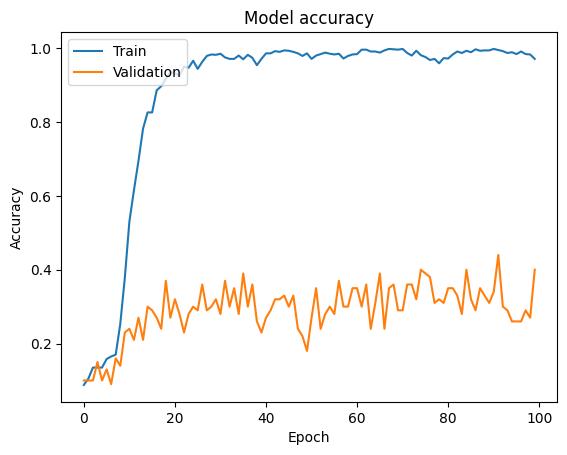

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

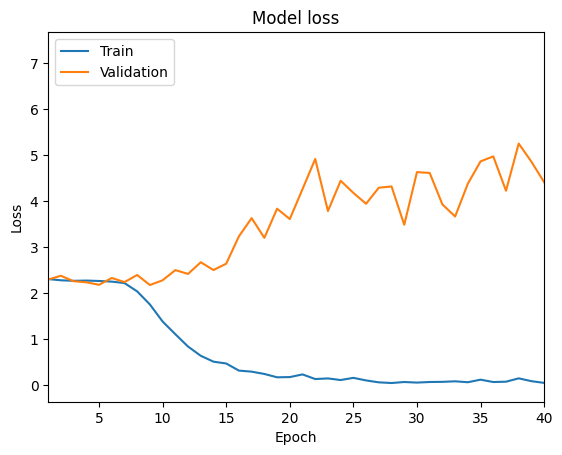

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
ypred = model.predict(eX_test)

4/4 [==============================] - 0s 14ms/step


In [28]:
predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)]

In [29]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
#     print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy} on completely unseen data")

Accuracy = 0.45 on completely unseen data
